In [1]:
# taken from https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

# Load data and prepare data-frame
# - strip unused columns 
# - add additional information

import pandas as pd
file = '../webserver/model_data/TrainingData_ml.xlsx'
df = pd.read_excel(file).rename(columns={'Effekt': 'category'})
col = ['utterance', 'category']
df = df[col]

df = df[pd.notnull(df['utterance'])]
df.columns = ['utterance', 'category']
df['category_id'] = df['category'].factorize()[0]
df['word_count'] = list(map(lambda x:len(x.split(' ')), df['utterance']))
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

df.head()

,utterance,category,category_id,word_count
0,Merkel war und ist hier eine getriebene,insinuation,0,7
1,Das ist doch albern.,lecture,1,4
2,Dass ich nicht lache,dissence,2,4
3,Sie haben schlicht gar nichts begriffen.,lecture,1,6
4,Stellen Sie sich nicht dumm,lecture,1,5


In [8]:
# filter for minimal word count
min_word_count = 3
df = df[df['word_count']>=min_word_count]

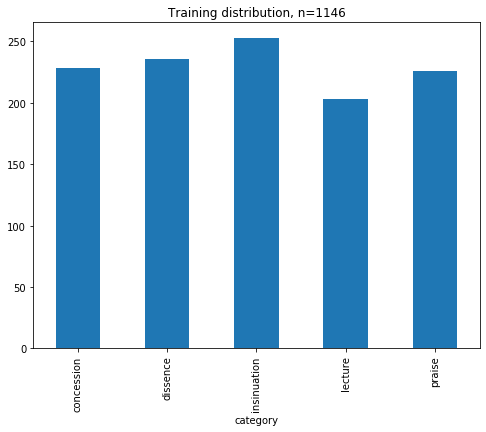

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').utterance.count().plot.bar(ylim=0)
plt.title('Training distribution, n={}'.format(len(df)))
plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 1))
# , stop_words=get_stop_words('de')
features = tfidf.fit_transform(df.utterance).toarray()
labels = df.category_id
features.shape

(1063, 1005)

In [36]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
features_chi2 = {}
feature_names = {}

for Effekt, category_id in sorted(category_to_id.items()):
  raw_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(raw_chi2[0])[::-1]
  feature_names[category_id] = np.array(tfidf.get_feature_names())[indices]
  features_chi2[category_id] = raw_chi2[0][indices]
  unigrams = [v for v in feature_names[category_id] if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names[category_id] if len(v.split(' ')) == 2]
  print("# '{}':".format(Effekt))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[0:N])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[0:N])))

# 'concession':
  . Most correlated unigrams:
. ja
. auch
  . Most correlated bigrams:
. 
# 'dissence':
  . Most correlated unigrams:
. ernst
. nein
  . Most correlated bigrams:
. 
# 'insinuation':
  . Most correlated unigrams:
. merkel
. sie
  . Most correlated bigrams:
. 
# 'lecture':
  . Most correlated unigrams:
. sollten
. erst
  . Most correlated bigrams:
. 
# 'praise':
  . Most correlated unigrams:
. danke
. sehr
  . Most correlated bigrams:
. 


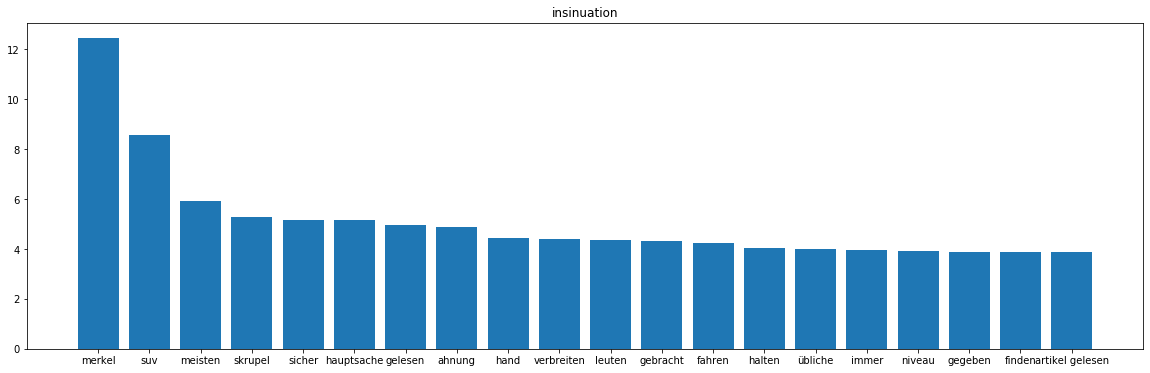

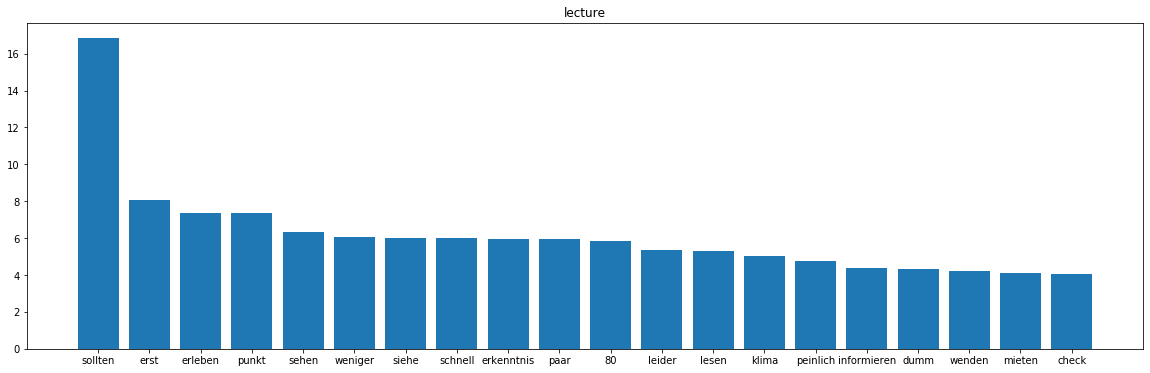

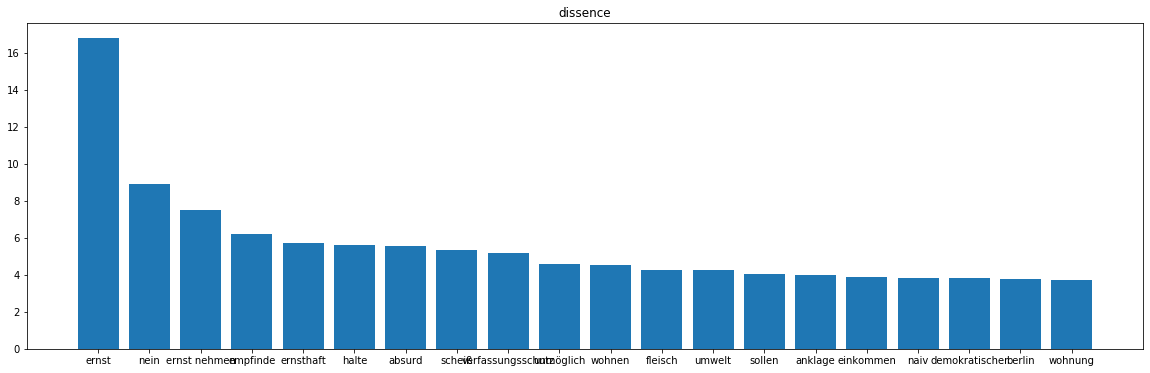

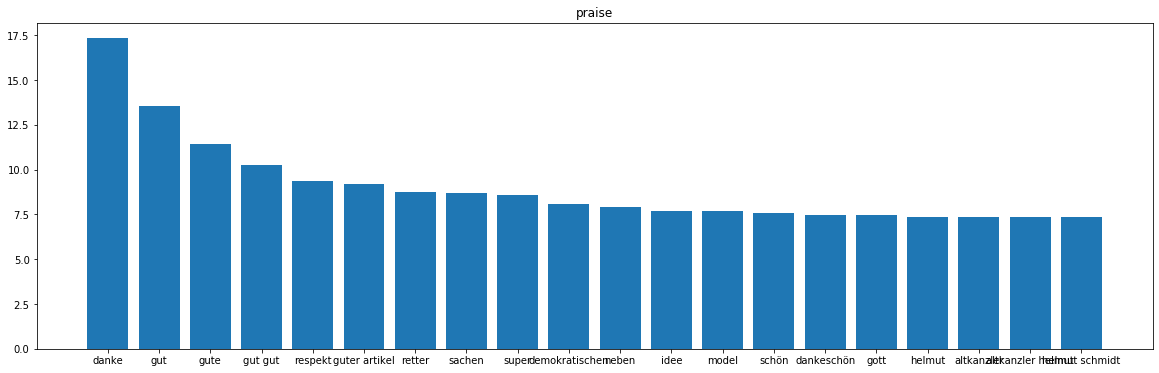

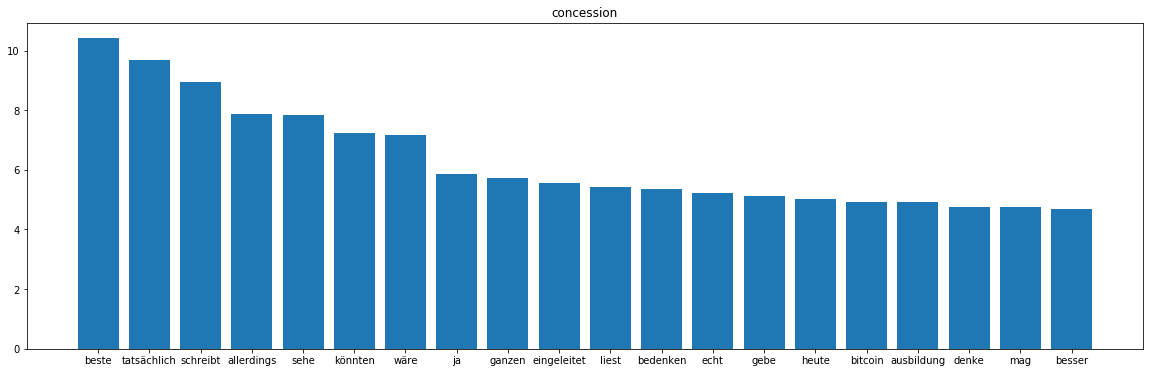

In [6]:
N = 20
for index, cat in id_to_category.items():
    fig = plt.figure(figsize=[20, 6])
    plt.bar(range(N), features_chi2[index][0:N])
    plt.xticks(range(N), feature_names[index][0:N])
    plt.title(cat)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['utterance'], df['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [12]:
print(clf.predict(count_vect.transform(["Da musst du aber noch mal ran, das muss noch besser werden!"])))

['insinuation']


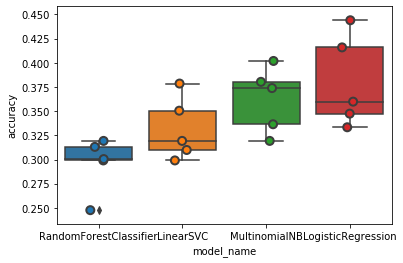

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [39]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.331429
LogisticRegression        0.380075
MultinomialNB             0.362336
RandomForestClassifier    0.295906
Name: accuracy, dtype: float64

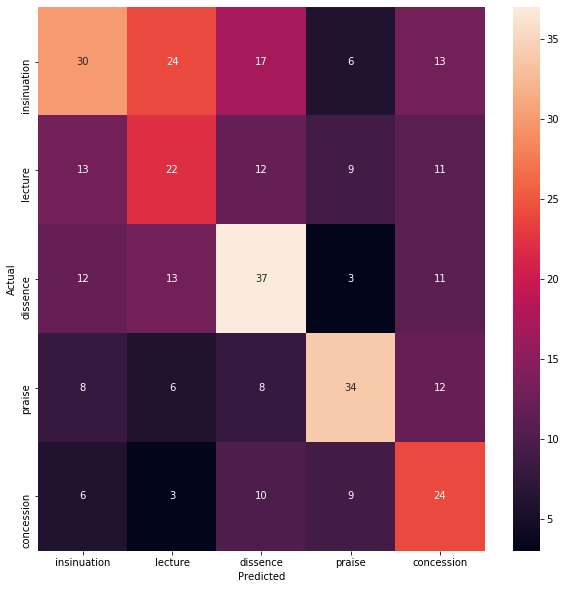

In [40]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [31]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'utterance']])
      print('')

'lecture' predicted as 'insinuation' : 16 examples.


,category,utterance
570,lecture,Das Problem ist hier weder die Sorglosigkeit d...
779,lecture,"Kaufen Sie im Bioladen, dann bekommen Sie ""ech..."
638,lecture,Extra für Sie noch mal ganz ausführlich…
1128,lecture,Ob Sie ihn für schuldig halten oder unsympathi...
1152,lecture,"Wenn Sie mal Energie speichern googeln, werden..."
401,lecture,Haben Sie den Schuss nicht gehört?
949,lecture,bleibt doch gleich für die Wirtschaft
975,lecture,"Fakt: Länge Porsche Cayenne 4,70"
791,lecture,"Abwarten.Nicht so schnell, nicht so emotional."
312,lecture,"Noch Fragen, Kienzle?"



'dissence' predicted as 'insinuation' : 12 examples.


,category,utterance
415,dissence,"Oh Mann Ericsson, ich habe noch nie einen Beit..."
1224,dissence,Das entspricht meiner Ansicht nach nicht den T...
519,dissence,"Immer wieder putzig, als wenn das ""mächtigste ..."
698,dissence,verlogen
449,dissence,Das ist doch kein Widerspruch.
639,dissence,Sie negieren allgemein bekannte Tatsachen.
457,dissence,Insofern ist weder die Befreiung von der Versi...
821,dissence,Ich habe von diesem besorgtbürgerlichen rechte...
911,dissence,Floskel-Kommentare dagegen nicht.
1140,dissence,"Heuchler allesamt, vor allen die Linken Grüne ..."



'insinuation' predicted as 'lecture' : 18 examples.


,category,utterance
1107,insinuation,"Es sieht eher so aus, als sind es die links-gr..."
902,insinuation,Das soll die Ambivalenz gegenüber der Gegenmei...
583,insinuation,"Das unpassende Wort Rassismus, ein Dauerbrenne..."
1174,insinuation,Ich nehme an Sie wählen afD?
644,insinuation,"Einige Männer ertragen es einfach nicht, dass ..."
253,insinuation,Sie müssen nicht von ihren Wünschen auf andere...
575,insinuation,"Neinnein, die spielt damit."
871,insinuation,"sie lockert überall Vorschriften, statt den Ve..."
278,insinuation,Sie brauchen dringend Nachhilfe in Sachen Demo...
797,insinuation,So langsam dürfte den Trumpistas etwas schwind...



'dissence' predicted as 'lecture' : 13 examples.


,category,utterance
758,dissence,Und für 100 m² Wohnung werden summen über 600....
227,dissence,Wo war hier bitte der Mindfuck?
26,dissence,erwarten Sie von mir keine ernsthafte Erwiderung.
709,dissence,Soll das ein Witz sein?
1149,dissence,Es ist bizarr wie pervers die Seele vieler Deu...
724,dissence,"bis sie sich zu einer kulisse verzerrt, die al..."
1218,dissence,Eher weniger... da wird viel unter Verschluss ...
440,dissence,Mit welcher Begründung sollen die denn hier we...
125,dissence,"Mir kommt die Missachtung der Gesetze, wenn si..."
47,dissence,"Indirekt stimmt der Zusammenhang also doch, de..."



'insinuation' predicted as 'dissence' : 22 examples.


,category,utterance
603,insinuation,"Es ist von Ihnen schon ziemlich abgebrüht, um ..."
378,insinuation,Die Sozis konnten noch nie mit Geld umgehen
735,insinuation,Unterstellungen eventuell unterlassen?
146,insinuation,Gauland gefällt dieses Video nicht
636,insinuation,Das macht Sie unsicher und nagt an Ihrem Selbs...
713,insinuation,Tja und jetzt bandelt die KTM wieder mit Pekin...
844,insinuation,Ich vermag an tanzenden Kindern nichts schlimm...
452,insinuation,Hab mir Ihre Kommentare mal durchgelesen
608,insinuation,denn dort wird kreativität ausgetrieben
416,insinuation,Auf was für ein Niveau wollen Sie die Diskussi...



'lecture' predicted as 'dissence' : 11 examples.


,category,utterance
701,lecture,niveaulos
685,lecture,toericht
983,lecture,Vielleicht nicht aus allem eine Glaubensfrage ...
1,lecture,Das ist doch albern.
536,lecture,Aha - und wo ist jetzt der Bezug zum Artikel?
405,lecture,Ihr Beitrag strotzt nur so vor Unwissen und Pa...
767,lecture,Was ist denn Ihrer Meinung nach eine angemesse...
396,lecture,Machen Sie sich nicht lächerlich.
683,lecture,lächerlich
403,lecture,Ihre Simplifizierungen suchen ihresgleichen.



'praise' predicted as 'dissence' : 10 examples.


,category,utterance
1083,praise,"Interessante Denkimpluse, die in die komplette..."
1159,praise,Das ist absolut glaubwürdig.
1086,praise,Biobauern sind nicht per se Fortschrittsfeindl...
754,praise,Go Johnny Go !
1004,praise,Sondern konstruktive Kommentare
1166,praise,Sie verhalten sich völlig richtig.
1056,praise,Vollste Zustimmung!
1026,praise,Großartig! Subtile Hinführung zur Katastrophe.
1096,praise,Ein wünschenswerter Trend
596,praise,Frauen frei von den patriarchalen Zwängen in B...



'concession' predicted as 'dissence' : 11 examples.


,category,utterance
1084,concession,Bemerkenswert fand ich vor allem diese Stelle
980,concession,(nicht ganz ernstgemeint)
876,concession,Ironie ein :
841,concession,"Soll jetzt keine Werbung sein, finde aber, das..."
998,concession,Simon J gebe ich dir absolut recht
835,concession,"Ich glaube, Herr Tellkamp hat recht."
1187,concession,Recht hat er
137,concession,"Mir fällt auf, dass ich immer häufiger als Rit..."
637,concession,"jedoch wissen wir doch alle, dass sich diese t..."
447,concession,"Richtig, der Terror findet nie ein Ende, aber ..."



'lecture' predicted as 'praise' : 10 examples.


,category,utterance
127,lecture,nämlich ab dem Zeitpunkt wo man versucht die M...
944,lecture,"Das Leben ist so, dass es keine Sicherheit gibt"
119,lecture,"Stefanie Breyer Keine Frage, nicht nur ein Ges..."
390,lecture,Für andere geht es halt um Umweltschutz und Rü...
1055,lecture,Zum Vergleich lohnt sich immer ein Blick in di...
901,lecture,Erst wird eine Situation möglichst bildlich be...
1117,lecture,Nur muss man solche aus den Fingern gesogene P...
885,lecture,Meine Frage lautet:
493,lecture,ich ergänze: und unzureichendes Leseverständni...
193,lecture,Immer zuerst dafür und dann andere Formen des ...



'insinuation' predicted as 'concession' : 12 examples.


,category,utterance
43,insinuation,Jetzt muss Dieter Nuhr doch glatt ein Drittel ...
626,insinuation,wenn ich all die schadenfrohen Kommentare hier...
914,insinuation,"Kommentatoren, die es besser wissen. Ich lach ..."
132,insinuation,"Es ist immer so, das Rettung und Überfahrt ver..."
630,insinuation,Noch so ein Spezialist der mir vor die Karre f...
810,insinuation,das will sie sicherlich auch nicht
978,insinuation,Wenn ich ein solches fahrzeug hätte würde ich ...
968,insinuation,aber genau so denkt der durchschnittsdeutsche
521,insinuation,Vom heimischen Sofa aus und ohne Verständnis f...
560,insinuation,"Die EU will Polen drin behalten, aber ich denk..."



'dissence' predicted as 'concession' : 10 examples.


,category,utterance
523,dissence,"Kommentatoren, die es besser wissen. Ich lach ..."
454,dissence,Welcher seltsame Populismus? Was genau meinen ...
542,dissence,Es geht auch nicht um Wahrheiten
107,dissence,Anne Ham geh lieber zu deine Rinder. Wir mögen...
882,dissence,was mich mit dem Nestle aufregt ist das Sie Ne...
165,dissence,Fünf Minuten probeliegen im Geschäft genügt mi...
741,dissence,"Es ist absurd, dass wir so ein Tier jeden Tag ..."
731,dissence,Es ignoriert die individuellen Situationen in ...
851,dissence,"Ich finde es komisch, dass so getan, wird, als..."
1179,dissence,"Hüther mag in Vielem recht haben, in einem Ber..."



'praise' predicted as 'concession' : 12 examples.


,category,utterance
965,praise,Die Frau ist symphatisch!
999,praise,Hammer Reporter
1168,praise,"Auf jeden Fall, ich stimme Ihnen zu."
1220,praise,"Überhaupt gibt es so viele gute Dinge, wo wir ..."
1219,praise,Da sollten wir uns in Deutschland ein Beispiel...
854,praise,"Ich finde es sehr interessant, Lebensentwürfe ..."
832,praise,In dem Fall finde ich es richtig.
57,praise,Da bot neulich das Interview mit dem Historike...
591,praise,"Ein kleiner Schritt für den Kopf, aber ein gro..."
101,praise,Dankeschön
